In [58]:
from importlib import reload
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()
import pmdarima
import darts
from statsmodels.graphics.tsaplots import plot_acf

# Silencing Pandas warnings
import warnings
warnings.filterwarnings("ignore", message="Could not infer format")
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

pd.set_option('max_colwidth', 400)
pd.options.display.float_format = lambda x: f"{x.item():0.3e}"
pd.options.display.max_rows = 80

In [3]:
from scripts.data_extraction import get_all_lobbying_data, lobbying_totals

lobbying_train = get_all_lobbying_data()

all_totals = lobbying_train.groupby("period_start")[["income", "expenses"]].sum()
all_totals["total"] = all_totals.sum(axis=1)

codes = [x.stem[-3:] for x in Path("lobbying_data/by_issue_code/").glob("*.csv")]
for code in codes:
    code_totals = lobbying_totals(code, adjust_for_num_codes=True)
    code_totals.columns = [code + "_" + x for x in code_totals.columns]
    all_totals = pd.merge(all_totals, code_totals, left_index=True, right_index=True)


In [7]:
all_totals.columns

Index(['income', 'expenses', 'total', 'ALC_lobbying_income',
       'ALC_lobbying_expenses', 'ALC_lobbying_income_variance',
       'ALC_lobbying_expenses_variance', 'ALC_lobbying_spending_variance',
       'ALC_lobbying_num_income', 'ALC_lobbying_num_expenses',
       ...
       'DEF_lobbying_total', 'TAR_lobbying_income', 'TAR_lobbying_expenses',
       'TAR_lobbying_income_variance', 'TAR_lobbying_expenses_variance',
       'TAR_lobbying_spending_variance', 'TAR_lobbying_num_income',
       'TAR_lobbying_num_expenses', 'TAR_lobbying_num', 'TAR_lobbying_total'],
      dtype='object', length=714)

In [20]:
from pmdarima import auto_arima

model = auto_arima(all_totals["FOO_lobbying_total"], seasonal=True, m=4)
model.fit(all_totals["FOO_lobbying_total"])
type(model.predict(4))

pandas.core.series.Series

(524360591266.25,
 ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 4),
       suppress_warnings=True, with_intercept=False))

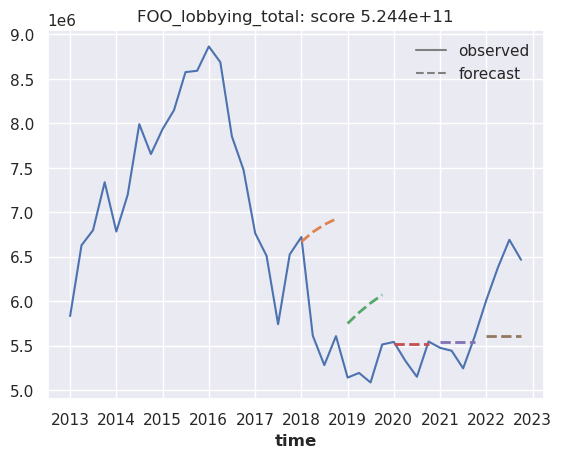

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from pmdarima import auto_arima

from sklearn.model_selection import TimeSeriesSplit

from darts import TimeSeries
from darts.metrics import mse

def cross_validate_auto_arima(col, plot=True, test_size=4, n_cv=5, metric=mse, **auto_arima_kwargs):
    kf = TimeSeriesSplit(n_cv, test_size=test_size)
    score = 0
    
    if plot:
        fig, ax = plt.subplots()
        sns.lineplot(col, ax=ax)
        forecast_line = mlines.Line2D([], [], color="gray", linestyle="dashed")
        true_line = mlines.Line2D([], [], color="gray", linestyle="solid")

    for train_idx, valid_idx in kf.split(col):
        col_train = col.iloc[train_idx]
        col_valid = col.iloc[valid_idx]
        model = auto_arima(col_train, **auto_arima_kwargs)
        model.fit(col_train)
        y_pred = model.predict(test_size)
        
        col_valid = TimeSeries.from_series(col_valid)
        y_pred = TimeSeries.from_series(y_pred)
        score += metric(col_valid, y_pred)

        if plot:
            y_pred.plot(linestyle="dashed", ax=ax)
            
    score = score / kf.get_n_splits()
    
    if plot:
        ax.legend(labels = ["observed", "forecast"], handles=[true_line, forecast_line])
        ax.set_title(col.name + f": score {score:0.3e}")
        
    return score, model
cross_validate_auto_arima(
    col=all_totals["FOO_lobbying_total"],
    seasonal=True,
    m=4,
)

In [61]:
from darts.models import NaiveDrift
scores = pd.DataFrame(index=codes, columns=["ARIMA_MSE", "Drift_MSE", "ARIMA_best_order", "ARIMA_best_seasonal_order"])

for code in codes:
    col = all_totals[f"{code}_lobbying_total"]
    score, model = cross_validate_auto_arima(col, seasonal=True, m=4, plot=False, error_action="ignore")
    scores.loc[code, "ARIMA_MSE"] = score
    scores.loc[code, "ARIMA_best_order"] = model.order
    scores.loc[code, "ARIMA_best_seasonal_order"] = model.seasonal_order
    
    naive_score = cross_validate(NaiveDrift(), col, plot=False)
    scores.loc[code, "Drift_MSE"] = naive_score

/home/pvk/miniconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


In [62]:
scores

,ARIMA_MSE,Drift_MSE,ARIMA_best_order,ARIMA_best_seasonal_order
ALC,2.102e+11,1.161e+11,"(1, 0, 0)","(1, 0, 0, 4)"
ECN,3.171e+12,4.284e+12,"(0, 1, 0)","(0, 0, 0, 4)"
CPI,1.091e+12,1.080e+12,"(1, 1, 0)","(0, 0, 0, 4)"
TRU,1.661e+11,1.162e+11,"(1, 0, 0)","(1, 1, 1, 4)"
SCI,3.708e+12,3.545e+12,"(0, 1, 0)","(0, 0, 0, 4)"
APP,9.789e+09,7.238e+09,"(1, 0, 0)","(1, 1, 0, 4)"
NAT,1.208e+12,9.625e+11,"(0, 1, 0)","(0, 0, 0, 4)"
FIR,4.594e+11,5.076e+11,"(1, 0, 0)","(0, 0, 1, 4)"
GOV,9.848e+12,4.263e+12,"(0, 1, 0)","(0, 0, 0, 4)"
IMM,8.675e+11,1.696e+12,"(1, 0, 0)","(0, 0, 0, 4)"


(714710975085.3263,
 ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 4),
       suppress_warnings=True, with_intercept=False))

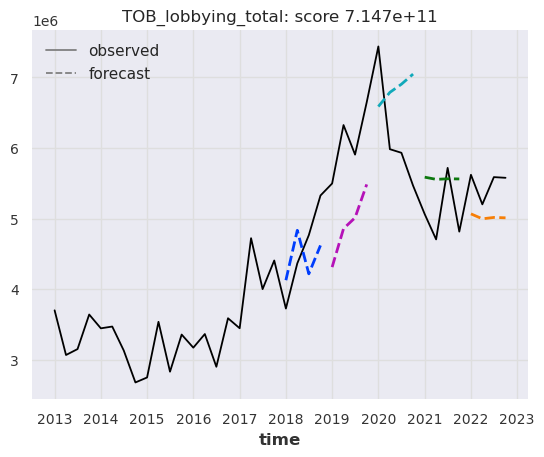

In [57]:
cross_validate_auto_arima(all_totals["TOB_lobbying_total"], seasonal=True, m=4)